# Обработка данных с датчика

Необходимо автоматически выявлять и заполнять следующие аномалии в данных
- пропуски
- выбросы 

## Первичный анализ данных за год

### Загрузка и преобразование данных

In [123]:
import pandas as pd
import ast
import json
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()

In [87]:
puid_df = pd.read_csv('samples/p9445_2024.csv')

In [88]:
puid_df['keys'] = puid_df['keys'].apply(ast.literal_eval)
puid_df['values'] = puid_df['values'].apply(ast.literal_eval)
puid_df['meta'] = puid_df['meta'].apply(ast.literal_eval)

In [89]:
puid_df[:5]

,ts,__insert_ts,keys,values,meta,anomaly
0,2024-05-10 05:20:00,2024-05-13 05:21:06,"[[volume, c1, c2, c3, c4, c5, c6, c7, speed, o...","[[30, 9, 14, 3, 1, 2, 1, null, 78.53125, 3.847...","[{""direction"":1,""lane"":1}, {""direction"":1,""lan...",[]
1,2024-05-10 05:25:00,2024-05-13 05:21:06,"[[volume, c1, c2, c3, c4, c5, c6, c7, speed, o...","[[30, 14, 14, 2, 0, 0, 0, null, 80.55469, 3.10...","[{""direction"":1,""lane"":1}, {""direction"":1,""lan...",[]
2,2024-05-10 05:30:00,2024-05-13 05:21:06,"[[volume, c1, c2, c3, c4, c5, c6, c7, speed, o...","[[44, 28, 15, 0, 0, 1, 0, null, 78.80859, 4.62...","[{""direction"":1,""lane"":1}, {""direction"":1,""lan...",[]
3,2024-05-10 05:35:00,2024-05-13 05:21:06,"[[volume, c1, c2, c3, c4, c5, c6, c7, speed, o...","[[40, 26, 11, 1, 0, 2, 0, null, 75.41797, 4.60...","[{""direction"":1,""lane"":1}, {""direction"":1,""lan...",[]
4,2024-05-10 05:40:00,2024-05-13 05:21:06,"[[volume, c1, c2, c3, c4, c5, c6, c7, speed, o...","[[36, 18, 14, 1, 0, 2, 1, null, 86.62891, 4.08...","[{""direction"":1,""lane"":1}, {""direction"":1,""lan...",[]


### Парсинг столбцов

- meta - список источников данных. От каждого источника поступает набор данных перечисленных в keys 
- keys - наборы ключей для каждого источника. К примеру если meta длины 4 то keys тоже длины 4 и каждый элемент keys - список, содержащий наблюдаемые параметры
- values - значения параметров. Размерность совпадает с keys

Извлечение метаданных. Они константные для датчика

In [90]:
meta = list(map(json.loads, puid_df['meta'][0]))
meta

[{'direction': 1, 'lane': 1},
 {'direction': 1, 'lane': 2},
 {'direction': 0, 'lane': 1},
 {'direction': 0, 'lane': 2}]

In [91]:
titles = list(map(lambda x: f'{"Прямое" if  x["direction"] == 1 else "Обратное"}, полоса {x["lane"]}', meta))
titles

['Прямое, полоса 1',
 'Прямое, полоса 2',
 'Обратное, полоса 1',
 'Обратное, полоса 2']

Маппинг значений по ключам. Для начала будем использовать только основные параметры
- volume
- speed 
- occupancy

In [92]:
keys = puid_df['keys'][0][0]
general_key_indices = [keys.index('volume'), keys.index('speed'), keys.index('occupancy')]
general_key_indices

[0, 8, 9]

In [93]:
# получение значений из первого источника в meta
def get_processor(source_index):
    def process_keys(row):
        return pd.Series(map(lambda i: pd.to_numeric(row['values'][source_index][i], errors='coerce'), general_key_indices), index=map(lambda i: keys[i], general_key_indices))
    
    return process_keys

params_df =  puid_df.apply(get_processor(0), axis=1)
puid_source_0 = pd.concat([puid_df['ts'], params_df], axis=1)

In [94]:
puid_source_0['ts'] = pd.to_datetime(puid_source_0['ts'])
puid_source_0.set_index('ts', inplace=True)
puid_source_0.index = pd.to_datetime(puid_source_0.index)

In [95]:
puid_source_0.dtypes

volume       float64
speed        float64
occupancy    float64
dtype: object

In [96]:
puid_source_0.index.dtype

dtype('<M8[ns]')

<Axes: xlabel='ts'>

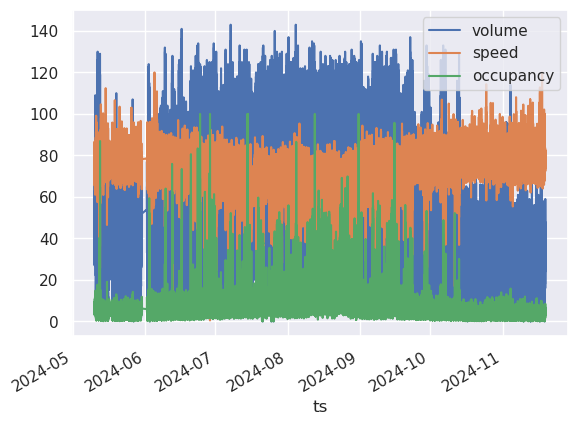

In [97]:
puid_source_0.plot()

In [98]:
puid_source_0[:10]

,volume,speed,occupancy
ts,,,
2024-05-10 05:20:00,30.0,78.531250,3.847656
2024-05-10 05:25:00,30.0,80.554690,3.105469
2024-05-10 05:30:00,44.0,78.808590,4.628906
2024-05-10 05:35:00,40.0,75.417970,4.609375
2024-05-10 05:40:00,36.0,86.628910,4.082031
2024-05-10 05:45:00,38.0,76.582030,4.523438
2024-05-10 05:50:00,44.0,80.183590,4.558594
2024-05-10 05:55:00,35.0,83.546875,3.691406
2024-05-10 06:00:00,30.0,79.605470,3.121094


In [99]:
puid_source_0.describe()

,volume,speed,occupancy
count,62749.000000,62749.000000,62749.000000
mean,55.142520,71.377247,8.536781
std,32.361313,12.441948,8.634890
min,0.000000,0.484375,0.000000
25%,28.000000,69.050780,3.484375
50%,51.000000,73.664060,6.410156
75%,82.000000,77.882810,10.351562
max,143.000000,120.000000,100.000000


## Поиск пропущенных значений 

Данные собираются с интервалом в 5 минут. Необходимо найти timestamps в которые отсутствуют данные

Проверка индекса на дубликаты

In [100]:
puid_source_0.index.duplicated().sum()

7938

При наличии продублированных записей нужно определить какие данные оставлять 

In [101]:
puid_source_0[puid_source_0.index.duplicated(keep=False)]

,volume,speed,occupancy
ts,,,
2024-05-21 06:55:00,31.0,75.984375,3.332031
2024-05-21 06:55:00,31.0,75.984375,3.332031
2024-05-21 07:00:00,33.0,81.144530,3.371094
2024-05-21 07:00:00,33.0,81.144530,3.371094
2024-05-21 07:05:00,30.0,76.023440,4.339844
...,...,...,...
2024-11-14 09:05:00,28.0,75.632810,4.121094
2024-11-14 09:10:00,37.0,71.847660,5.761719
2024-11-14 09:10:00,37.0,71.847660,5.761719


Проверка на различные дубликаты

In [102]:
duplicates = puid_source_0.groupby(puid_source_0.index).nunique()
duplicates[duplicates.gt(1).any(axis=1)]

,volume,speed,occupancy
ts,,,


Так как дубликаты повторяются можно удалить их. Иначе можно усреднить или оставить только первое/последнее значение

In [103]:
puid_source_0 = puid_source_0[~puid_source_0.index.duplicated(keep='first')]

In [104]:
range2024 = pd.date_range('2024-01-01 00:00', '2024-12-31 23:55', freq='5Min')
puid_source_0_na = puid_source_0.reindex(range2024)
puid_source_0_na.describe()

,volume,speed,occupancy
count,54811.000000,54811.000000,54811.000000
mean,55.139187,71.447210,8.477453
std,32.201708,12.253072,8.530749
min,0.000000,0.484375,0.000000
25%,28.000000,69.089840,3.492188
50%,51.000000,73.632810,6.433594
75%,81.000000,77.832030,10.289062
max,143.000000,120.000000,100.000000


<Axes: >

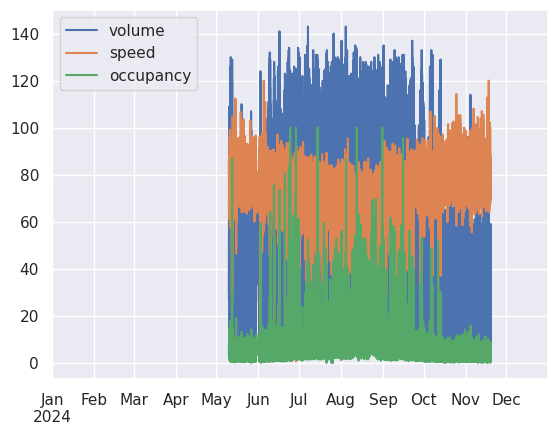

In [105]:
puid_source_0_na.plot()

In [106]:
# количество пятиминутных интервалов в году
rows_count = pd.Timestamp(2024, 12, 31).dayofyear * (24 * 60 / 5)
rows_count

105408.0

In [107]:
assert len(puid_source_0_na.index) == rows_count

Данные нормализованы по времени. Теперь необходимо корректно заполнить каждый тип пропущенных значений

## Заполнение пропусков

Заполнять пропуски можно 
- линейно
- скользящим окном 
- средними за период (день, неделя)
- средним за все ts в году (к примеру усредняем все значения каждого дня в 05:55:00)

Виды пропусков
- в определенное время дня
- целыми интервалами

Имеет смысл заполнять пропуски если их не большинство и они не регулярны весь период

### Определение характера пропущенных данных

In [108]:
puid_source_0_na = puid_source_0_na.reset_index()
puid_source_0_na['is_nan'] = puid_source_0_na['volume'].isna().astype(int)  
puid_source_0_na['group'] = (puid_source_0_na['is_nan'].diff() == 1).cumsum()  
nan_intervals = puid_source_0_na[puid_source_0_na['is_nan'] == 1].groupby('group').agg(start=('index', 'first'), end=('index', 'last'))

In [109]:
nan_intervals['duration'] = nan_intervals['end'] - nan_intervals['start'] 

In [110]:
nan_intervals

,start,end,duration
group,,,
0,2024-01-01 00:00:00,2024-05-10 05:15:00,130 days 05:15:00
1,2024-05-16 19:15:00,2024-05-17 11:35:00,0 days 16:20:00
2,2024-05-18 23:20:00,2024-05-18 23:20:00,0 days 00:00:00
3,2024-05-30 14:05:00,2024-06-01 16:25:00,2 days 02:20:00
4,2024-06-17 23:25:00,2024-06-17 23:25:00,0 days 00:00:00
5,2024-07-04 13:05:00,2024-07-04 13:05:00,0 days 00:00:00
6,2024-07-16 22:05:00,2024-07-16 22:05:00,0 days 00:00:00
7,2024-07-17 22:05:00,2024-07-17 22:05:00,0 days 00:00:00
8,2024-07-31 22:10:00,2024-07-31 22:10:00,0 days 00:00:00


In [ ]:
puid_source_0_na.drop(['is_nan', 'group'], axis=1, inplace=True)
puid_source_0_na.set_index('index', inplace=True)

In [136]:
def get_interval(index):
    return nan_intervals.loc[index].start, nan_intervals.loc[index].end

def plot_missing(df: pd.DataFrame, nan_df: pd.DataFrame):
    num_cols = 3
    fig, axs = plt.subplots(ncols=num_cols, nrows=nan_df.shape[0] // num_cols + 1, figsize=(25, 25))
    for (interval_data, i) in zip(nan_df.itertuples(index=False), range(nan_df.shape[0])):
        delta = interval_data.duration if interval_data.duration != pd.Timedelta(0) else pd.Timedelta(hours=1)
        df.loc[interval_data.start - delta:interval_data.end + delta].plot(ax=axs[i // num_cols, i % num_cols])

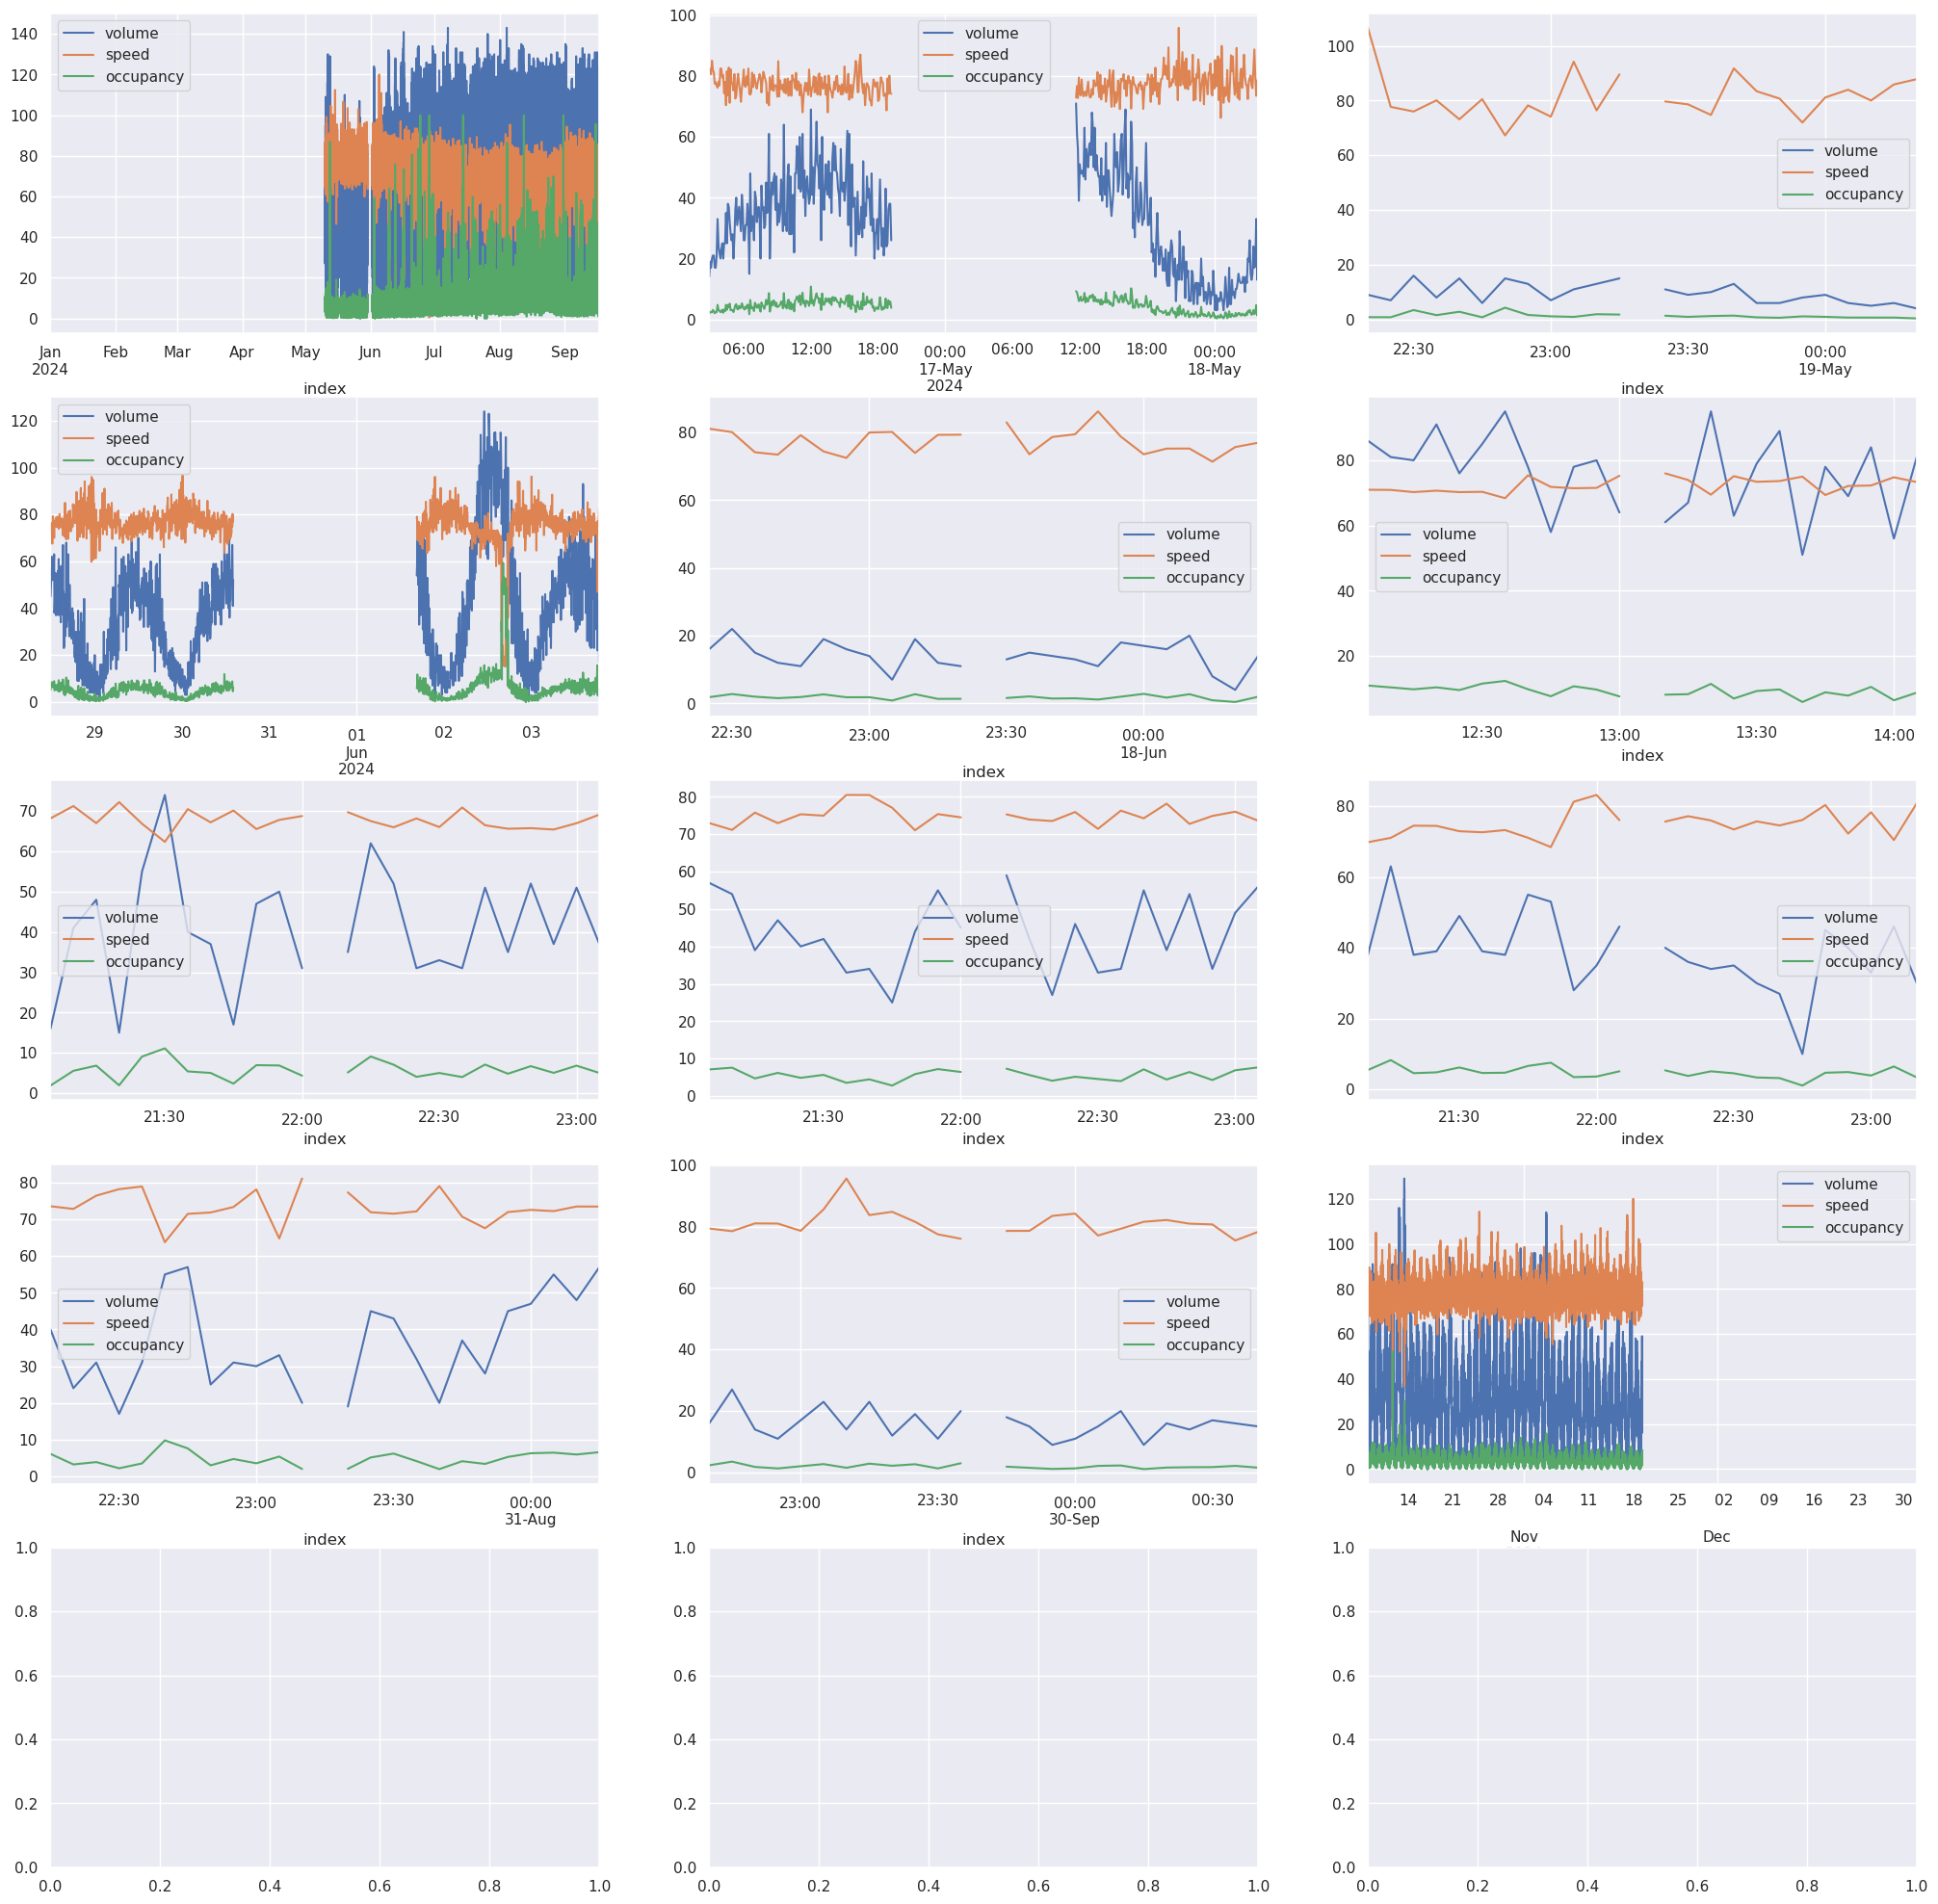

In [137]:
plot_missing(puid_source_0_na, nan_intervals)

#### 1. Пропуски интервалов длиной несколько дней 

## Поиск аномалий

Можно осуществлять несколькими методами. Удаление аномалий и повышение чистоты данных будет напрямую влиять на качество обучения

1. Экспертная оценка

- обратное и прямое направление отличаются в несколько раз (сюда же относится отсутствие трафика по одному направлению когда другое направление представлено)
- резко возрастает показатель интенсивности
- интенсивность изменяется несколько раз в сутки

2. Микросервис 